This notebook demonstrates **ISP latency assessment**, based on the paper "General Internet Service Assessment by Latency Including Blocked Measurements".

If custom data are used, please specify the variables below.

In [1]:
#RIPE Atlas probes
atlasfile = '20220202.json'

#country ISO A2 and A3 codes
countrya2 = 'CZ'; countrya3 = 'CZE'

#max latency observation points in country
pointmax = 200

#approx. location of the host OR set geo plot to False
geographicplot = False
endhostlat = 50; endhostlon = 16

#inputs are not validated for code simplicity

In [2]:
%%capture
!pip install numpy
!pip install shapely
!pip install pandas
!pip install matplotlib
!pip install geopandas
!pip install lifelines

In [3]:
#standard modules 
import sys; import os; import json; import glob

#data processing
import numpy as np; import pandas as pd 
import matplotlib.pyplot as plt

#geography
import geopandas as gpd
from shapely.geometry import LineString
from matplotlib.lines import Line2D

#survival analysis
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time
from lifelines.plotting import plot_lifetimes
from lifelines.plotting import rmst_plot
from lifelines.plotting import add_at_risk_counts

Process RIPE Atlas probes in country into observation points

In [4]:
#load RIPE Atlas file with list of probes
try:
    probes_js = json.load(open('atlas/'+atlasfile))
except:
    print('RIPE Atlas file'+' atlas/'+atlasfile+' does not exist or cannot be open')
    raise

#parse Atlas data
probes_pf = pd.DataFrame(probes_js['objects'])
probes_pf = probes_pf.filter(['id','address_v4','status_name','country_code','latitude','longitude'])
probes_pf = probes_pf.rename(columns={'id':'pointid','address_v4':'ip','status_name':'sts','country_code':'cntr','latitude':'lat','longitude':'lon'})
probes_pf.pointid = probes_pf.pointid.astype('str') 

#filter Atlas probes with IPv4 address, in specified country, and currently functional
points_pf = probes_pf.loc[(pd.notna(probes_pf.ip)) & (probes_pf.cntr == countrya2) & (probes_pf.sts == 'Connected')] 

del probes_pf

#reduce number of observation points for latency measurement if above pointmax
if len(points_pf) > pointmax:
    pointsmsr_pf = points_pf.sample(pointmax)
else:
    pointsmsr_pf = points_pf

#custom data = Atlas file of different name is uploaded
if atlasfile != '20220202.json':

    #store new latency observation points
    pointsmsr_pf.to_csv('points.csv',header=False,index=False)

#show latency observation points
#pointid - Atlas probe ID
#ip - Atlas probe IP address
#sts - Atlas probe current status
#cntr - Atlas probe country ISO A2
#lat,lon - Atlas probe coordinates
points_pf

,pointid,ip,sts,cntr,lat,lon
38,1000034,81.201.60.30,Connected,CZ,50.0895,14.4885
60,1000056,176.74.145.221,Connected,CZ,49.3105,16.6195
61,1000057,90.177.221.181,Connected,CZ,49.1905,16.5795
63,1000059,46.28.109.126,Connected,CZ,49.0515,14.4295
67,1000063,84.242.77.74,Connected,CZ,50.0085,14.4505
...,...,...,...,...,...,...
34943,6810,78.128.211.119,Connected,CZ,50.0975,14.3875
34993,6856,188.92.41.251,Connected,CZ,50.0805,14.4495
35112,6963,185.178.172.32,Connected,CZ,50.0785,14.5205
35180,7024,93.190.128.178,Connected,CZ,50.0595,14.4785


Read provided latency data OR custom latency data

In [5]:
latencyfiles_ls = sorted(glob.glob("latency/*.json"),reverse = False)

Process latency data for survival analysis

In [6]:
#ping measurements
def ping(file):
    latency = np.nan
    pointip = np.nan
    observed = False

    msr_pf = pd.read_json(file)

    #response is present
    if len(msr_pf) > 0: 
        pointip = msr_pf.destination_ip.iloc[0]

        if msr_pf.packets_received.iloc[0] > 0:
            latency = round(msr_pf.round_trip_ms_avg.iloc[0])
            observed = True

    return [latency,observed,pointip]

#traceroute measurements
def hop(path):
    latency = np.nan
    latency_ls = []

    try:
        for i in range(3):  
            latency_ls.append(path[i]['rtt'])

        latency  = round(sum(latency_ls)/len(latency_ls))

    except:
        return latency  
    
    return latency

def trace(file):
    latency = np.nan
    pointip = np.nan
    observed = False

    msr_pf = pd.read_json(file)

    if len(msr_pf) > 0:

        pointip = msr_pf.destination_ip.iloc[0]

        msr_pf = msr_pf.reset_index(drop=True)
        msr_pf = msr_pf.join(pd.json_normalize(msr_pf.hops))

        #avg latency for each hop
        msr_pf['latency'] = msr_pf.probes.apply(hop)

        #max unobserved latency
        latency = msr_pf.latency.max()

        #it is possible that ping failed but trace reached the end, we still keep max latency on the path
        lastip = msr_pf.loc[msr_pf.latency == latency].probes.values[0][0]['ip']

        if lastip == pointip:
            observed = True
        else:
            observed = False
    
    return [latency,observed,pointip]

latency_pf = pd.DataFrame(columns=['latency','observed','pointip','latencytype','pointid','hostid','filename'])

for path in latencyfiles_ls:

    latency_ls = []

    filename = os.path.basename(path)
    basename = os.path.basename(path).split('.')[0]
    hostid = basename.split('_')[0]
    pointid = basename.split('_')[1]
    latencytype = basename.split('_')[2]

    if latencytype == 'ping':
        pointlatency_ls = ping(path)
    
    #if trace exists it has preference
    if latencytype == 'trace':
        pointlatency_ls = trace(path)

    if len(pointlatency_ls) > 0:

            pointlatency_ls.extend([latencytype,pointid,hostid,filename])
            
            latency_pf.loc[len(latency_pf.index)] = pointlatency_ls 

    else:
        print('Unknown latency type',path)

#remove lat <= 1, just getway is reached
latency_pf = latency_pf.loc[latency_pf.latency > 1]

#remove lat = NA
latency_pf = latency_pf.drop(latency_pf.loc[pd.isna(latency_pf.latency)].index)

#retype
latency_pf.latency = latency_pf.latency.astype('int')
latency_pf.observed = latency_pf.observed.astype('bool') #for lifelines

#show number of observed and unobserved latency values
print('Latency observed:\n', latency_pf.observed.value_counts())

#show latency values
#pointip - Atlas probe IP
#pointid - Atlas probe ID
#hostid - end host ID from where latency was measured
#filename - original file with stored latency measurement
latency_pf

Latency observed:
 True     189
False     63
Name: observed, dtype: int64


,latency,observed,pointip,latencytype,pointid,hostid,filename
0,15,True,81.201.60.30,ping,1000034,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_1000034_ping....
1,18,True,176.74.145.221,ping,1000056,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_1000056_ping....
2,22,True,90.177.221.181,ping,1000057,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_1000057_ping....
3,16,True,46.28.109.126,ping,1000059,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_1000059_ping....
4,17,True,84.242.77.74,ping,1000063,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_1000063_ping....
...,...,...,...,...,...,...,...
317,13,True,78.128.211.119,ping,6810,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_6810_ping.json
318,12,True,188.92.41.251,ping,6856,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_6856_ping.json
319,14,True,185.178.172.32,ping,6963,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_6963_ping.json
320,13,True,93.190.128.178,ping,7024,ef4add9f2d1c428e82690c5db7f404ba,ef4add9f2d1c428e82690c5db7f404ba_7024_ping.json


Plot latency observation links in country

In [7]:
%%capture --no-display

if geographicplot:

    #fill host location
    latency_pf['hostlat'] = endhostlat;latency_pf['hostlon'] = endhostlon

    #fill observation point (Atlas probe) location 
    latency_pf['pointlat'] = np.nan;latency_pf['pointlon'] = np.nan
    for pointid in latency_pf.pointid:
        latency_pf.loc[latency_pf.pointid == pointid,'pointlat'] = points_pf.loc[points_pf.pointid == pointid].lat.values[0]
        latency_pf.loc[latency_pf.pointid == pointid,'pointlon'] = points_pf.loc[points_pf.pointid == pointid].lon.values[0]

    #clip map to country (ISO A3)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
    world = world[world['iso_a3'].isin([countrya3])]
    ax = world.plot(color='white', edgecolor='black',figsize=(8, 12))
    ax.set_aspect('equal')
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')

    #transform to geopandas
    latency_gpf = gpd.GeoDataFrame(latency_pf)
    latency_gpf['pointcrd'] = gpd.points_from_xy(latency_pf.pointlon,latency_pf.pointlat)
    latency_gpf['hostcrd'] = gpd.points_from_xy(latency_pf.hostlon,latency_pf.hostlat)

    #create lines between host and observation points
    latency_gpf['lines'] = gpd.GeoSeries(latency_gpf.apply(lambda row: LineString([row.pointcrd,row.hostcrd]),axis=1))
    latency_gpf.lines = latency_gpf.lines.set_crs(world.crs)

    #plot observation points and host
    latency_gpf.pointcrd.plot(ax=ax, marker='+', color='black', markersize=150)
    latency_gpf.hostcrd.plot(ax=ax, marker='o', color='black', markersize=150)
    
    #plot observation links - observed and unobserved latency
    latency_gpf.loc[latency_gpf.observed == True].lines.plot(ax=ax, color='brown')
    latency_gpf.loc[latency_gpf.observed == False].lines.plot(ax=ax,  linestyle='dashed',color='royalblue')

    legend_elements = [
        Line2D([0], [0], color='black', marker='+', linestyle='none', lw=2, markersize=15, label='Latency observation point'),
        Line2D([0], [0], color='black', marker='o', linestyle='none', markersize=5,label='Host analyzed'),
        Line2D([0], [0], color='brown', lw=2, label='Observed latency'),
        Line2D([0], [0], color='royalblue', lw=2, linestyle='--', label='Unobserved latency (censored)'),
        Line2D([0], [0], color='black', lw=2, label='Country border')
        ]

    ax.legend(handles=legend_elements, loc='upper right')
    plt.axis('off')

    plt.show()

Process survival latency and show median survival

19.0


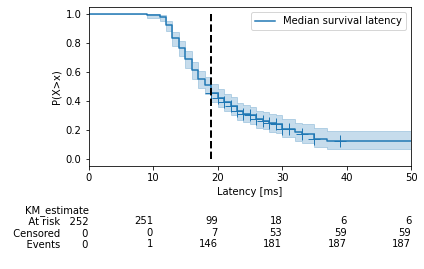

In [8]:
#use Kaplan-Meier estimator
survivallatency = KaplanMeierFitter().fit(latency_pf.latency,latency_pf.observed)

#get median survival
survivalmedian = survivallatency.median_survival_time_

print(survivalmedian)

ax = survivallatency.plot(label='Median survival latency',show_censors=True)
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('P(X>x)')
ax.vlines(survivalmedian,0,1, lw=2, linestyles='--',color='black')
ax.legend(loc='upper right')
ax.set_xlim([0, 50])

#add event table (sample)
add_at_risk_counts(survivallatency,ax=ax)

plt.tight_layout()

Show full survival latency table

In [9]:
survivallatency.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,252,252
9.0,1,1,0,0,252
11.0,4,4,0,0,251
12.0,14,14,0,0,247
13.0,23,23,0,0,233
14.0,17,17,0,0,210
15.0,19,19,0,0,193
16.0,19,19,0,0,174
17.0,16,16,0,0,155


Process mean traditional latency and restricted mean survival latency

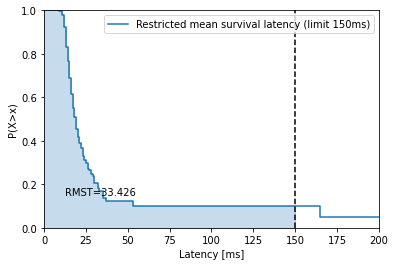

In [10]:
%%capture --no-display

limit = 150 # to exclude latency caused by temporary networking problems

#use the limit also for observed latency
#mean latency from observed latency only
simplemean = round(latency_pf.loc[(latency_pf.observed == True) & (latency_pf.latency < limit)].latency.mean())

#survival mean latency including unobserved values
restrictedsurvivalmean = round(restricted_mean_survival_time(survivallatency, t=limit))

ax = rmst_plot(survivallatency, t=limit, label='Restricted mean survival latency (limit 150ms)')
ax.set_ylabel('P(X>x)')
ax.set_xlabel('Latency [ms]')
ax.set_xlim([0, 200])

plt.show()

Show ISP latency assessment by **mean traditional latency** and by **restricted mean survival latency**

In [11]:
print('Mean traditional latency:',simplemean,'ms')
print('Restricted mean survival latency:',restrictedsurvivalmean,'ms')
print()
print('Difference of mean traditional and survival latency:',restrictedsurvivalmean-simplemean,'ms')

Mean traditional latency: 18 ms
Restricted mean survival latency: 33 ms

Difference of mean traditional and survival latency: 15 ms
